In [71]:
import logging

logging.basicConfig(level=logging.INFO)

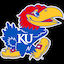

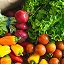

In [72]:
from pathlib import Path
from PIL import Image
from sympy import Matrix

from qcc.quantum.pennylane.ansatz import MQCC as Module

from qcc.quantum.pennylane.c2q import ConvolutionAngleFilter, ConvolutionComplexAngleFilter, ConvolutionFilter

dims = (64, 64, 3)

size = "x".join((str(dim) for dim in dims))
filenames = [Path(f"../img/color/Jayhawk_{size}.jpg"), Path(f"../img/color/Salad_{size}.jpg")]
batch_size = len(filenames)

for filename in filenames:
    with Image.open(filename, "r") as im:
        display(im)

def display_matrix(matrix):
    try:
        Matrix(matrix)
    except:
        print(matrix)

In [73]:
from qcc.filters import *

fltrs_raw = [avg_filter(3, dim = 2), avg_filter(3, dim = 2)]
# fltr_raw = sobel_filter(3, axis=0)
# fltr_raw = laplacian_approx(3)
# fltr_raw = gaussian_blur(3)

fltrs = []
for fltr_raw in fltrs_raw:
    npad = tuple((0, 2 ** int(np.ceil(np.log2(N))) - N) for N in fltr_raw.shape)
    fltr = np.pad(fltr_raw, pad_width=npad, mode="constant", constant_values=0)
    fltrs += [fltr]

num_features = len(fltrs)
filter_shape = fltrs_raw[0].shape

for fltr in fltrs:
    display_matrix(fltr)

In [74]:
from qcc.quantum import flatten_image, normalize

inputs = (flatten_image(filename, pad=True)[0] for filename in filenames)

inputs, magnitudes = zip(*(normalize(psi, include_magnitude=True) for psi in inputs))

inputs, magnitudes = np.vstack(inputs), tuple(magnitudes)

In [75]:
# Ansatz parameters
module_options = {
    "U_filter": ConvolutionFilter,
    "num_features": num_features,
    "U_fully_connected": None,
    "pooling": False,
    "filter_shape": filter_shape,
}

INFO:qcc.quantum.pennylane.ansatz.ansatz:Depth: 16
INFO:qcc.quantum.pennylane.ansatz.ansatz:Gate Count: 119


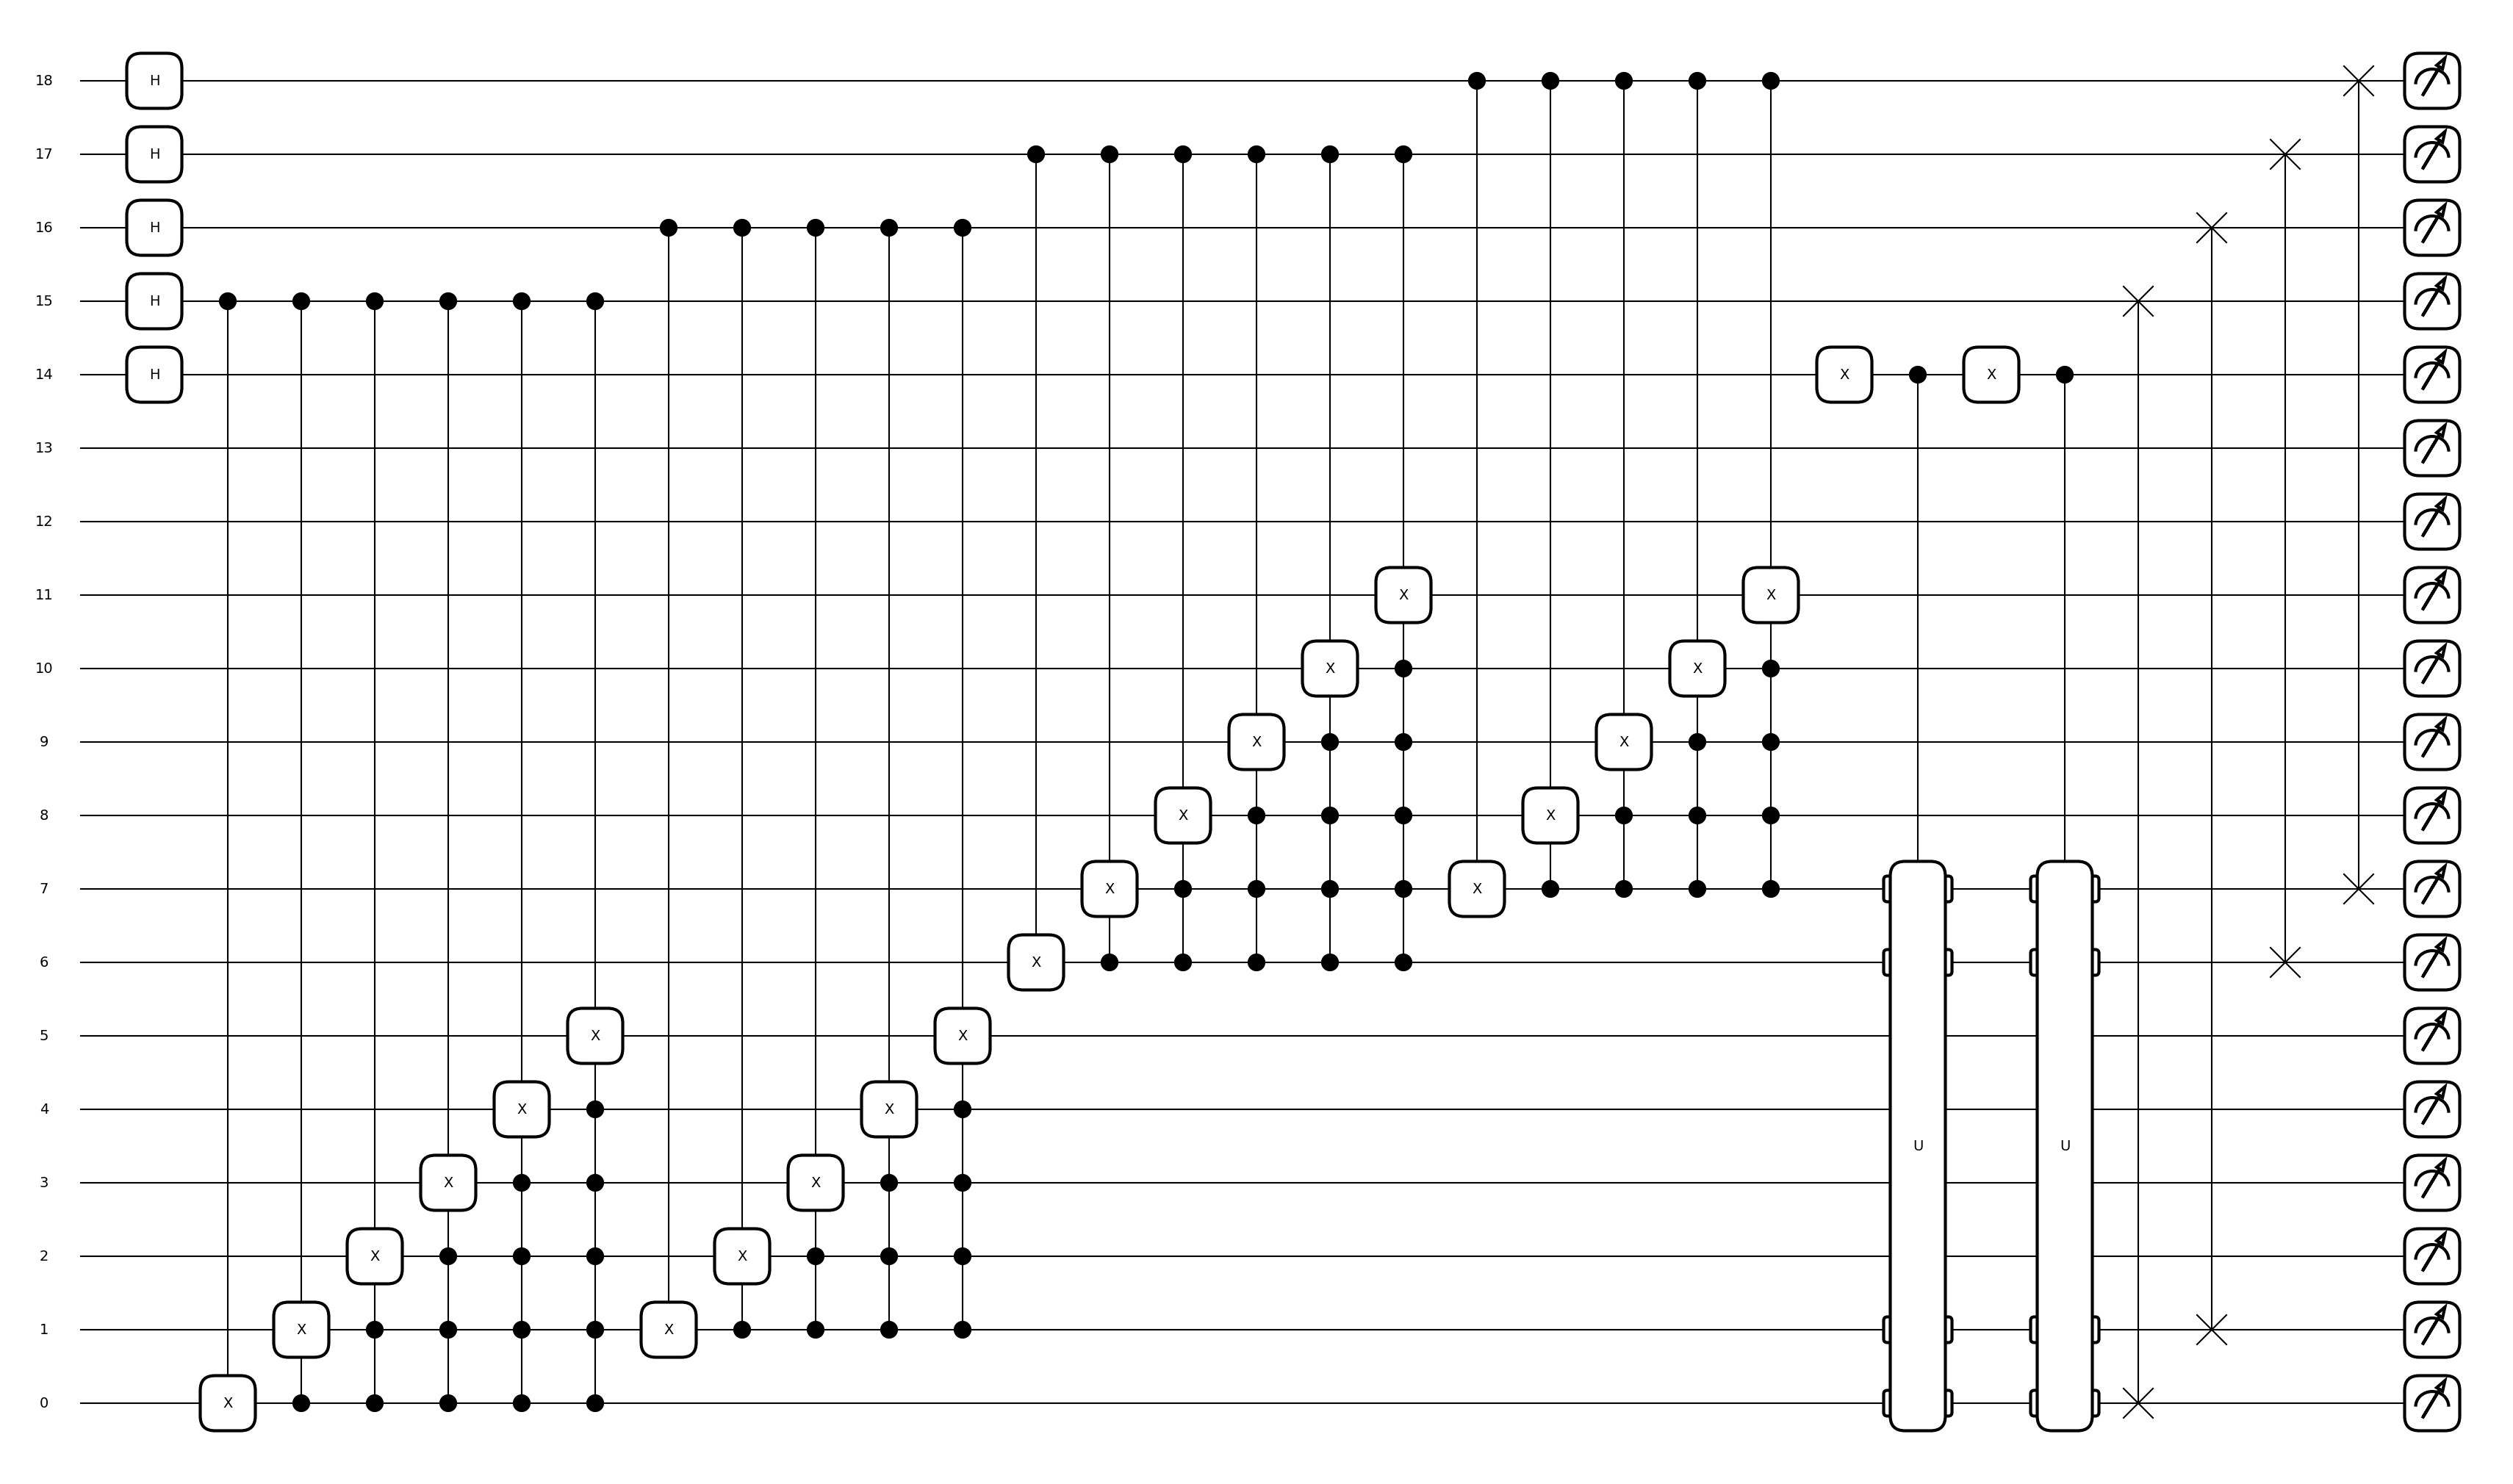

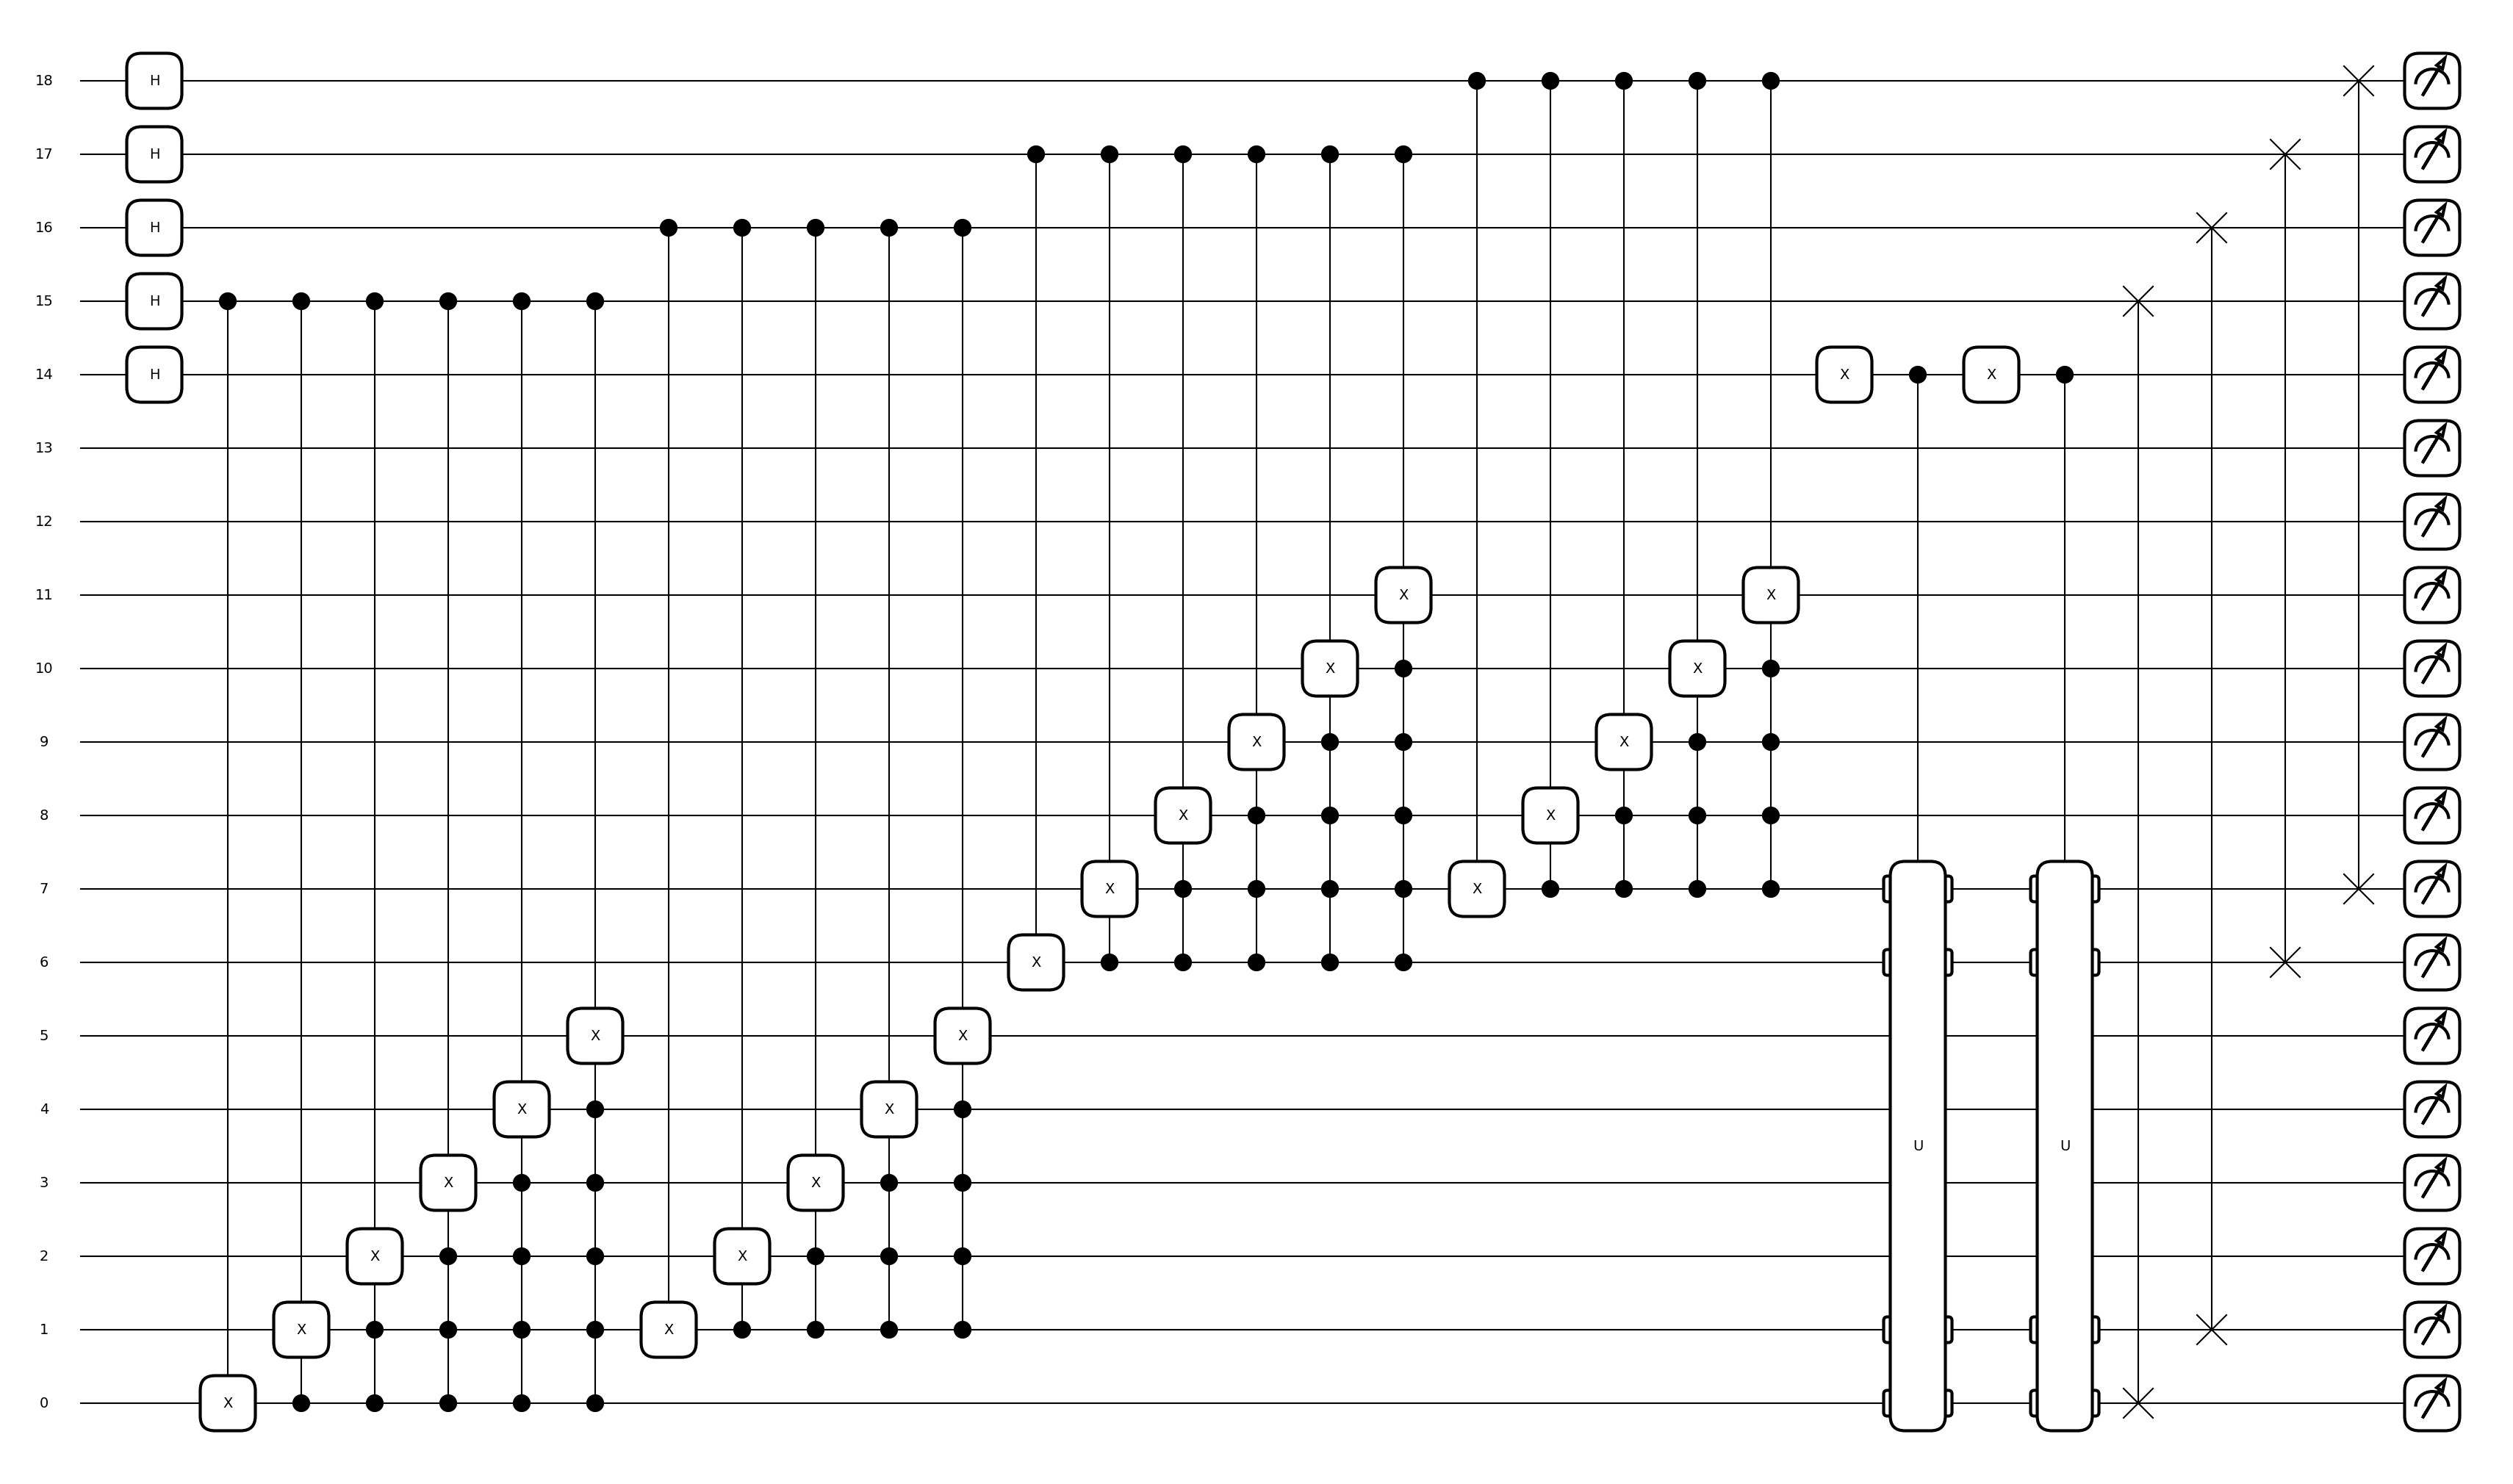

In [76]:
# Create module
module = Module.from_dims(
    dims,
    num_layers=1,
    **module_options,
)

fig = module.draw(decompose=True)

In [77]:
from torch import Tensor
from torch.nn import Parameter

params, fltrs_mag = zip(*(normalize(fltr.flatten(order="F"), include_magnitude=True) for fltr in fltrs))
params, fltrs_mag = np.vstack(params), tuple(fltrs_mag)

# PyTorch assume row-major order
module.weight = Parameter(Tensor(params.flatten()))

display_matrix(module.weight.data)

In [78]:
from qcc.quantum import reconstruct

result = module(inputs)

# Column-major correction (batch_size)
result = result.moveaxis(0, -1) 

# Correct for pooling
dims = update_dims(dims, kernel_size=module.pooling, stride=module.pooling)

dims_out = update_dims(dims, module.filter_shape)
dims = (batch_size, *dims, module.num_features)
dims_out = (batch_size, *dims_out, module.num_features)

result = reconstruct(result, dims, dims_out)

result.shape

torch.Size([2, 62, 62, 3, 2])

In [79]:
result = result.cpu().detach().numpy()

(62, 62, 3) 0.0 255.00000759959204


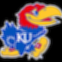

(62, 62, 3) 0.0 255.00000759959204


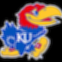

(62, 62, 3) 0.0 254.77778537074713


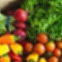

(62, 62, 3) 0.0 254.77778537074713


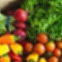

In [80]:
result = np.moveaxis(result, -1, 1)
for images, mag in zip(result, magnitudes):
    for img, fltr_mag in zip(images, fltrs_mag):
        img = mag * fltr_mag * img[:,:]
        
        print(img.shape, min(img.flatten()), max(img.flatten()))

        img = Image.fromarray(np.abs(img).astype(np.uint8))

        display(img)